In [7]:
import numpy as np
import matplotlib.pyplot as plt
import z5py
from pathlib import Path

from cryofib.affine_utils import get_scaling_transform
from cryofib.n5_utils import read_volume

from scipy.ndimage import affine_transform

## Set paths

In [4]:
scratch_dir = Path("/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem")
fluo_dir = scratch_dir / "fluo"
fluo_n5_path = fluo_dir / "fluo.n5"
segm_em_nuclei_dir = scratch_dir / "segm_em_nuclei"
segm_em_nuclei_path = segm_em_nuclei_dir / "em_nuclei.n5"


em_dir = scratch_dir / "em"
em_n5_path = em_dir / "em.n5"

f_fluo = z5py.File(fluo_n5_path, "r")
f_em = z5py.File(em_n5_path, "r")
f_segm_em_nuclei = z5py.File(segm_em_nuclei_path, "r")

In [10]:
ds = f_em["raw"]
resolution_em = ds.attrs["resolution"]
transform_key = "ref_affine_transform"
R = np.array(ds.attrs[transform_key]["R"])
print("Affine transform from napari")
print(R)
R_inv = np.linalg.inv(R)
print("Inverse")
print(R_inv)

Affine transform from napari
[[ 9.97290717e-01 -7.35610333e-02 -0.00000000e+00 -1.29347738e+04]
 [-5.85773859e-03 -7.94152563e-02  9.96824410e-01  1.09508498e+05]
 [-7.33274336e-02 -9.94123730e-01 -7.96309992e-02  1.29746573e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.97290717e-01 -5.85773859e-03 -7.33274336e-02  2.30551852e+04]
 [-7.35610333e-02 -7.94152563e-02 -9.94123730e-01  1.36729298e+05]
 [ 4.84526259e-19  9.96824410e-01 -7.96309992e-02 -9.88288947e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [11]:
roi = np.s_[:]
fluo = read_volume(f_fluo, "raw", roi)
ds = f_fluo["raw"]
resolution_fluo = ds.attrs["resolution"]

Reading roi slice(None, None, None) of volume raw from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/fluo/fluo.n5
Read volume with shape (55, 3343, 1482), data type uint8


In [9]:
em = read_volume(f_em, "raw", roi)

Reading roi slice(None, None, None) of volume raw from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em/em.n5
Read volume with shape (1410, 1386, 1610), data type uint8


In [21]:
R_scale_fluo = get_scaling_transform([1/x for x in resolution_fluo])
print(R_scale_fluo)

[[5.40686672e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.51671183e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.51671183e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [29]:
print("Resolution", resolution_fluo)
print("Shape", fluo.shape)
fluo_scaled_shape = [int(x * scale) for x, scale in zip(resolution_fluo, fluo.shape)]
print("Output shape", fluo_scaled_shape)

Resolution [1849.5, 221.4, 221.4]
Shape (55, 3343, 1482)
Output shape [101722, 740140, 328114]


In [30]:
fluo_scaled = affine_transform(fluo, R_scale_fluo, order=0)

MemoryError: Unable to allocate 21.9 PiB for an array with shape (101722, 740140, 328114) and data type uint8

In [50]:
R_scale_em = get_scaling_transform([y/x for x, y in zip(resolution_em, resolution_fluo)])
R_scale_em_1 = get_scaling_transform([1/x for x, y in zip(resolution_em, resolution_fluo)])
R_scale_em_2 = get_scaling_transform([y for x, y in zip(resolution_em, resolution_fluo)])
print(R_scale_em)

[[61.65   0.     0.     0.   ]
 [ 0.     7.38   0.     0.   ]
 [ 0.     0.     5.535  0.   ]
 [ 0.     0.     0.     1.   ]]


In [35]:
em_scaled = affine_transform(em, R_scale_em, order=0, output_shape=fluo.shape)

In [52]:
em_registered = affine_transform(em, R_scale_em_1 @ R_inv @ R_scale_em_2, order=0, output_shape=fluo.shape)

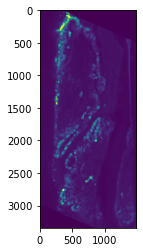

In [36]:
plt.imshow(fluo[30, :, :])

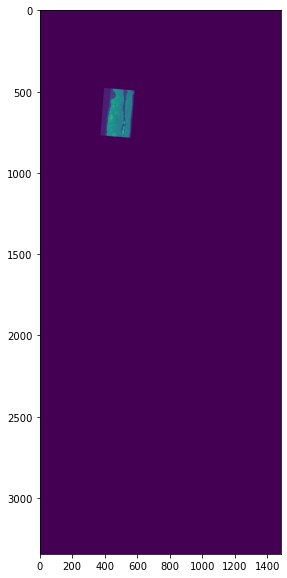

In [53]:
plt.figure(figsize=(10, 10))
plt.imshow(em_registered[0, :, :])

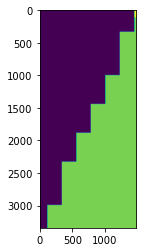

In [26]:
plt.imshow(fluo_scaled[30, :, :])

In [25]:
fluo_scaled.shape

(55, 3343, 1482)